In [75]:
import networkx as nx
from bqm_utils import graph_viz, tsp_viz
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from typing import Optional
from qiskit.quantum_info import SparsePauliOp

ImportError: cannot import name 'EstimatorV2' from 'qiskit_ibm_runtime' (c:\Users\pably\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_ibm_runtime\__init__.py)

## Overview

This notebook implements the computation of the Hamiltonian which we will optimize, `H`. The calculation iterates over a set of values, summing contributions from different terms to `H`.

## Definitions

- `H`: A scalar value initialized to zero. It accumulates the total energy.
- `N`: The size of the system.
- `A_1`, `A_2`: Coefficients for the penalty terms related to constraints on the variables.
- `B`: Coefficient of system hamiltonian
- `xvp`: A matrix of shape `(N, N)` initialized to zero. It represents some variable interactions or states.
- `V`: A vector of size `N`, initialized to zero, possibly representing individual variable.
- `h_v`: A randomly initialized matrix of shape `(N, N)`.




In [ ]:
H = 0
N = 4
A_1 = 0
A_2 = 0
B = 0 # Try also random initialization
x = np.zeros(shape = (N,N))
V = np.arange(1,N)
h_v = np.random.rand(N,N)
x0 = x[:,0]
for v in V:
    sum_p_for_v = 0
    for p in range(0, N-1):
        sum_p_for_v += x[v][p] # This is used in the third term
        H += B * p * h_v * x[v][p] # First term

    H += A_2 * (1 - sum_p_for_v)**2 # Third term

sum_x_v0 = sum(x0[v] for v in V)
H += A_1 * (1 - sum_x_v0)**2 # Second term

## Calculation Process

1. **Interaction Term Calculation**:
   - Iterate over each element in vector `V`. For each element, calculate the sum of products and interactions over the range of indices from 1 to `N-1`.
   - For each interaction, the contribution to `H` involves the product of `B`, an index `p`, the matrix `h_v`, and the matrix `xvp`. This term aggregates interaction-based contributions to the energy.

2. **Constraint on Sum of Variables**:
   - After the interaction terms, calculate the penalty for deviations from a sum constraint. The constraint forces the sum of `xvp` across a dimension to be close to 1, with `A_2` scaling the penalty for any deviation squared.

3. **Initial State Constraint**:
   - Extract the initial state vector `xv0` from the first column of `xvp`.
   - Compute the sum of `xv0` across all elements and apply a penalty for deviation from 1, scaled by `A_1`. This represents a constraint on the initial state of the system.


c:\Users\pably\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:305: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


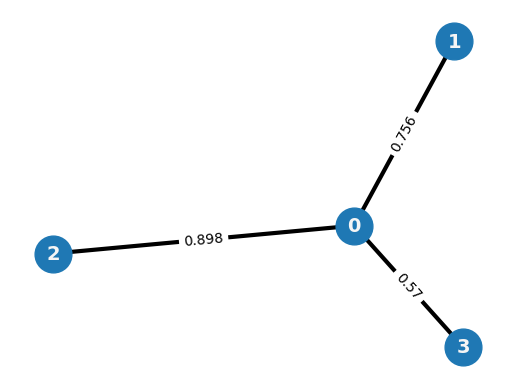

In [ ]:

G1 = nx.random_tree(4,seed = 19)
for u, v in G1.edges():
    G1[u][v]["weight"] = np.round(np.random.rand(),3)
graph_viz(G1)

In [ ]:
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2})
print(qubo.prettyprint())

Problem name: 

Minimize
  x*y - x*z + 2*y*z + x - 2*y + 3*z

Subject to
  No constraints

  Binary variables (3)
    x y z



# Feed Optimization Problem Using QUBO

The `FeedOpt` class is specifically designed to solve the feed optimization problem using Quantum Quadratic Unconstrained Binary Optimization (QUBO). This document provides a detailed overview of its implementation and usage.

## Overview

The `FeedOpt` class integrates with the Qiskit Optimization module to create and solve QUBO models. It is used to optimize feed scenarios based on predefined constraints and objectives, leveraging quantum computing capabilities for potentially superior performance on certain types of optimization problems.

## Class Initialization

- **Required Parameters**: 
  - `nodes`: Represents the nodes in the optimization model.
  - `edges`: Represents the edges between nodes, indicating possible interactions or relationships.
  - `haq_score`: A matrix representing specific scores or weights for the relationships, which are critical in the optimization process.

### Example of Parameters Initialization:

```python
params = {
    "nodes": np.random.rand(4, 2),  # Random nodes
    "edges": np.random.rand(4, 4),  # Random edges
    "haq_score": np.random.rand(4, 4)  # Random weights
}


In [ ]:


class FeedOpt:
    """Class for the feed optimization problem using QUBO"""
    REQUIRED_PARAMS = ["nodes", "edges","haq_score"]

    def __init__(self, params):
        for label in self.REQUIRED_PARAMS:
            if label not in params:
                raise ValueError(f"Please provide {label} in params.")
        
        self.params = params.copy()
        self.n_nodes = len(self.params["nodes"])
        self.A1 = params.get('A1', 0)  # Second term constant
        self.A2 = params.get('A2', 0)  # Third term constant
        self.B = params.get('B', 0)    # First term multiplier
        self.x = np.zeros((self.n_nodes, self.n_nodes))  # Decision variable matrix

        # Prepare QUBO model
        self.quadratic_program = self.gen_quadratic_program()

    def gen_quadratic_program(self):
        """Generate the Quadratic Program."""
        qubo = QuadraticProgram(name="Feed")
        for i in range(self.n_nodes):
            qubo.binary_var(name=f"x_{i}")

        # Objective function
        H = 0
        x = self.x
        B = self.B
        A1 = self.A1
        A2 = self.A2

        # Building the QUBO matrix
        for v in range(1, self.n_nodes):  # Note: Adjust indexing if needed
            sum_p_for_v = 0
            for p in range(self.n_nodes-1):
                sum_p_for_v += x[v, p]  # Accumulate decision variable usage
                # Adding first term contributions
                H += B * p * self.params['haq_score'][v, p] * x[v, p]

            # Adding third term contributions
            H += A2 * (1 - sum_p_for_v) ** 2

        # Calculate sum for the second term
        sum_x_v0 = np.sum(x[:, 0])
        H += A1 * (1 - sum_x_v0) ** 2

        # Set the model objective
        qubo.minimize(constant=H)

        return qubo

    def _run_gate_based_opt(self, quantum_instance: Optional[QuantumInstance] = None, label: str = "qaoa", opt_type: str = "qaoa"):
        opt_types = {"qaoa": QAOA}
        quantum_algo = opt_types[opt_type]

        if quantum_instance is None:
            backend = Aer.get_backend("qasm_simulator")
            quantum_instance = QuantumInstance(backend=backend)

        solver = quantum_algo(quantum_instance=quantum_instance)
        optimizer = MinimumEigenOptimizer(solver)

        result = optimizer.solve(self.quadratic_program)

        self.results[label] = result
        return self.results[label]

    def solve(self, method="qaoa", quantum_instance: Optional[QuantumInstance] = None):
       # """Solve the FEED problem using specified quantum method (QAOA or VQE)."""
        return self._run_gate_based_opt(quantum_instance=quantum_instance, opt_type=method)


# Parameters for simulation
params = {
    "nodes": np.random.rand(4, 2),  # Random nodes
    "edges": np.random.rand(4, 4),  # Random edges
    "haq_score": np.random.rand(4, 4),  # Random weights (as an example)
}

# Instantiate and use the class
feedopt = FeedOpt(params)
qubo_model = feedopt.quadratic_program
print(qubo_model.export_as_lp_string())
solve = feedopt.solve(method = 'qaoa')




minimize 0 (4 variables, 0 constraints, 'Feed')


C:\Users\pably\AppData\Local\Temp\ipykernel_7488\3376839730.py:62: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend)
C:\Users\pably\AppData\Local\Temp\ipykernel_7488\3376839730.py:64: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  solver = quantum_algo(quantum_instance=quantum_instance)


AttributeError: 'SparsePauliOp' object has no attribute 'primitive_strings'

In [82]:


import numpy as np
from qiskit import Aer, QuantumCircuit, execute
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from qiskit.utils import QuantumInstance

class FeedOpt:
    """Class for the feed optimization problem using QUBO"""
    REQUIRED_PARAMS = ["nodes", "edges", "haq_score"]

    def __init__(self, params):
        self.params = params.copy()
        self.params["nodes"] = self.params["nodes"]
        self.params["edges"] = self.params["edges"]
        self.params["n_nodes"] = len(self.params["nodes"])
        self.params["A1"] = self.params.get('A1', 1)  # Second term constant
        self.params["A2"] = self.params.get('A2', 1)  # Third term constant
        self.params["B"] = self.params.get('B', 1)    # First term multiplier

        self._quadratic_program = None
        self._lin_terms = None
        self._quadratic_terms = None

    @property
    def lin_terms(self):
        if self._lin_terms is None:
            self._generate_coefficients()
        return self._lin_terms

    @property
    def quadratic_terms(self):
        if self._quadratic_terms is None:
            self._generate_coefficients()
        return self._quadratic_terms

    @property
    def quadratic_program(self):
        if self._quadratic_program is None:
            self._quadratic_program = self._generate_quadratic_program()
        return self._quadratic_program

    def _generate_coefficients(self):
        """Generate coefficients for the QUBO model."""
        linear = {}
        quadratic = {}

        for v in range(self.params["n_nodes"]):
            for p in range(self.params["n_nodes"]):
                if v == p:
                    continue
                if (v, p) in quadratic:
                    quadratic[(v, p)] += self.params['B'] * p * self.params['haq_score'][v, p]
                else:
                    quadratic[(v, p)] = self.params['B'] * p * self.params['haq_score'][v, p]

        for v in range(self.params["n_nodes"]):
            linear[v] = linear.get(v, 0) + self.params['A2']
            if v == 0:
                linear[v] += self.params['A1']

        self._lin_terms = linear
        self._quadratic_terms = quadratic

    def _generate_quadratic_program(self):
        """Generate and return the Quadratic Program for the QUBO."""
        qubo = QuadraticProgram("Feed")
        for i in range(self.params["n_nodes"]):
            qubo.binary_var(name=f"x_{i}")
        qubo.minimize(linear=self.lin_terms, quadratic=self.quadratic_terms)
        return qubo

    def solve(self, method="qaoa"):
        """Solve the FEED problem using specified quantum method (QAOA)."""
        backend = Aer.get_backend('statevector_simulator')
        quantum_instance = QuantumInstance(backend=backend)

        if method.lower() == 'qaoa':
            solver = QAOA(quantum_instance=quantum_instance)
        else:
            raise ValueError("Unsupported method. Please use 'qaoa'.")

        optimizer = MinimumEigenOptimizer(solver)
        result = optimizer.solve(self.quadratic_program)
        return result

# Parameters for simulation
params = {
    "A1": 1,
    "A2": 1,
    "B": 1,
    "nodes": np.random.rand(4, 2),  # Random nodes
    "edges": np.random.rand(4, 4),  # Random edges
    "haq_score": np.random.rand(4, 4)  # Random weights (as an example
}

# Instantiate and use the class
feedopt = FeedOpt(params)
solve = feedopt.solve(method='qaoa')
print(solve)



C:\Users\pably\AppData\Local\Temp\ipykernel_7488\2480036712.py:76: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend)
C:\Users\pably\AppData\Local\Temp\ipykernel_7488\2480036712.py:79: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  solver = QAOA(quantum_instance=quantum_instance)


AttributeError: 'SparsePauliOp' object has no attribute 'primitive_strings'

In [84]:
from qiskit_optimization import QuadraticProgram

class FeedOpt:
    """Class for the feed optimization problem using QUBO"""

    def __init__(self, params):
        self.params = params.copy()
        self.params["n_nodes"] = len(self.params["nodes"])
        self.params["A1"] = self.params.get('A1', 1)  # Second term constant
        self.params["A2"] = self.params.get('A2', 1)  # Third term constant
        self.params["B"] = self.params.get('B', 1)    # First term multiplier

        self._quadratic_program = None
        self._lin_terms = None
        self._quadratic_terms = None

    @property
    def quadratic_program(self):
        if self._quadratic_program is None:
            self._quadratic_program = self._generate_quadratic_program()
        return self._quadratic_program

    def _generate_quadratic_program(self):
        """Generate and return the Quadratic Program for the QUBO."""
        qubo = QuadraticProgram("Feed")

        # Using dictionary to add binary variables for each node
        var_names = {f"x_{i}": 1 for i in range(self.params["n_nodes"])}
        qubo.binary_var_dict(var_names)

        # Adding the objective function with linear and quadratic terms
        qubo.minimize(linear=self.lin_terms, quadratic=self.quadratic_terms)
        
        return qubo

    def _generate_coefficients(self):
        """Generate coefficients for the QUBO model."""
        linear = {}
        quadratic = {}

        for v in range(self.params["n_nodes"]):
            for p in range(self.params["n_nodes"]):
                if v == p:
                    continue
                # Using a consistent ordering for indices in quadratic terms
                index = (min(v, p), max(v, p))
                quadratic[index] = quadratic.get(index, 0) + self.params['B'] * p * self.params['haq_score'][v][p]

        for v in range(self.params["n_nodes"]):
            linear[v] = linear.get(v, 0) + self.params['A2']
            if v == 0:
                linear[v] += self.params['A1']

        self._lin_terms = linear
        self._quadratic_terms = quadratic

# Example usage:

params = {
    "A1": 1,
    "A2": 1,
    "B": 1,
    "nodes": [[0, 1], [1, 2], [2, 3], [3, 0]],  # Example node structure
    "edges": [],  # Not used in this formulation
    "haq_score": [[0, 1, 2, 3], [1, 0, 2, 3], [2, 3, 0, 1], [3, 2, 1, 0]]  # Example haq scores
}

feed_opt = FeedOpt(params)
qp = feed_opt.quadratic_program
print(qp.export_as_lp_string())


TypeError: 'dict' object cannot be interpreted as an integer